# Variational Quantum Classifier (VQC) for NSL-KDD

This notebook implements a **Hybrid Quantum-Classical Classifier** for Network Intrusion Detection using PennyLane.

**Model Architecture:**
- Classical Preprocessing: Dimensionality reduction (122 → 8 features via PCA)
- Quantum Circuit: 8-qubit variational circuit with strongly-entangling layers
- Classical Postprocessing: Dense layers for final classification

**Dataset:** NSL-KDD  
**Task:** Binary Classification (Normal vs Attack)  
**Framework:** PennyLane + PyTorch

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# PennyLane for Quantum ML
try:
    import pennylane as qml
    from pennylane import numpy as pnp
    print(f"PennyLane version: {qml.__version__}")
    PENNYLANE_AVAILABLE = True
except ImportError:
    print("WARNING: PennyLane not installed. Install with: pip install pennylane")
    PENNYLANE_AVAILABLE = False

# Import custom models
from src.models.quantum.pennylane_models import HybridQuantumClassifier

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("All imports successful!")

PennyLane version: 0.43.2
All imports successful!


In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Verify PennyLane is ready
if PENNYLANE_AVAILABLE:
    print(f"\nPennyLane is ready! You can use quantum devices.")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Memory: 6.4 GB

PennyLane is ready! You can use quantum devices.


## 2. Configuration

In [3]:
# Paths
DATA_PATH = project_root / 'data' / 'raw' / 'nsl-kdd'
RESULTS_PATH = project_root / 'results' / 'models' / 'quantum'
LOGS_PATH = project_root / 'results' / 'logs'
FIGURES_PATH = project_root / 'results' / 'figures'

# Create directories
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
LOGS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Quantum Configuration
N_QUBITS = 8  # Number of qubits in quantum circuit
N_QUANTUM_LAYERS = 4  # Depth of quantum circuit
QUANTUM_DEVICE = 'default.qubit'  # PennyLane quantum simulator

# Training Configuration
BATCH_SIZE = 32  # Smaller batch size for quantum (slower computation)
EPOCHS = 50
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10

# For quick testing, use subset of data
USE_SUBSET = True  # Set to False for full training
SUBSET_SIZE = 10000  # Number of samples to use if USE_SUBSET=True

print(f"Quantum Config: {N_QUBITS} qubits, {N_QUANTUM_LAYERS} layers")
print(f"Training Config: Batch={BATCH_SIZE}, Epochs={EPOCHS}, LR={LEARNING_RATE}")
print(f"Using subset: {USE_SUBSET} ({SUBSET_SIZE if USE_SUBSET else 'Full'} samples)")

Quantum Config: 8 qubits, 4 layers
Training Config: Batch=32, Epochs=50, LR=0.001
Using subset: True (10000 samples)


## 3. Load and Preprocess Data

In [4]:
# NSL-KDD column names
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Load data
print("Loading NSL-KDD dataset...")
train_df = pd.read_csv(DATA_PATH / 'train_full.txt', header=None, names=COLUMNS)
test_df = pd.read_csv(DATA_PATH / 'test.txt', header=None, names=COLUMNS)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Loading NSL-KDD dataset...
Training samples: 25,192
Test samples: 22,544


In [5]:
# Convert to binary classification (Normal=0, Attack=1)
train_df['binary_label'] = (train_df['label'] != 'normal').astype(int)
test_df['binary_label'] = (test_df['label'] != 'normal').astype(int)

print("Training distribution:")
print(train_df['binary_label'].value_counts())
print("\nTest distribution:")
print(test_df['binary_label'].value_counts())

Training distribution:
binary_label
0    13449
1    11743
Name: count, dtype: int64

Test distribution:
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [6]:
def preprocess_data(train_df, test_df):
    """
    Preprocess NSL-KDD data with encoding and scaling.
    """
    # Identify categorical columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    
    # One-hot encode categorical features
    train_encoded = pd.get_dummies(train_df, columns=categorical_cols)
    test_encoded = pd.get_dummies(test_df, columns=categorical_cols)
    
    # Align columns (test may have missing categories)
    train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)
    
    # Drop non-feature columns
    drop_cols = ['label', 'difficulty', 'binary_label']
    feature_cols = [c for c in train_encoded.columns if c not in drop_cols]
    feature_cols = sorted(feature_cols)
    
    X_train = train_encoded[feature_cols].values
    X_test = test_encoded[feature_cols].values
    y_train = train_df['binary_label'].values
    y_test = test_df['binary_label'].values
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler, feature_cols

X_train_full, X_test, y_train_full, y_test, scaler, feature_cols = preprocess_data(train_df, test_df)

print(f"Features: {len(feature_cols)}")
print(f"X_train shape: {X_train_full.shape}")
print(f"X_test shape: {X_test.shape}")

Features: 118
X_train shape: (25192, 118)
X_test shape: (22544, 118)


## 4. Dimensionality Reduction with PCA

NSL-KDD has 122 features, which is too many for direct quantum encoding. We'll use PCA to reduce to 8 features to match our qubit count.

Applying PCA: 118 → 8 features

PCA Results:
Explained variance by 8 components: 0.2855 (28.55%)
Reduced shape - Train: (25192, 8), Test: (22544, 8)


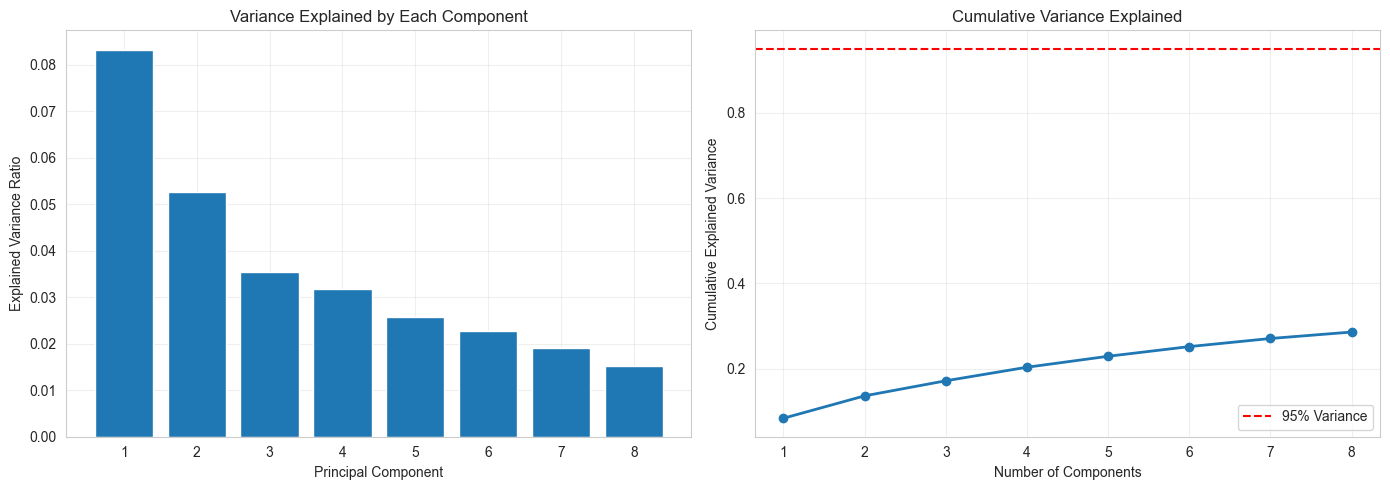

In [7]:
# Apply PCA to reduce dimensions to match qubit count
print(f"Applying PCA: {X_train_full.shape[1]} → {N_QUBITS} features")

pca = PCA(n_components=N_QUBITS, random_state=SEED)
X_train_pca = pca.fit_transform(X_train_full)
X_test_pca = pca.transform(X_test)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\nPCA Results:")
print(f"Explained variance by {N_QUBITS} components: {cumulative_var[-1]:.4f} ({cumulative_var[-1]*100:.2f}%)")
print(f"Reduced shape - Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")

# Visualize explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(1, N_QUBITS+1), explained_var)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Variance Explained by Each Component')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, N_QUBITS+1), cumulative_var, marker='o', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'vqc_pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Use subset for faster training/testing
if USE_SUBSET and SUBSET_SIZE < len(X_train_pca):
    indices = np.random.choice(len(X_train_pca), SUBSET_SIZE, replace=False)
    X_train_pca = X_train_pca[indices]
    y_train_full = y_train_full[indices]
    print(f"Using subset of {SUBSET_SIZE:,} samples for training")

# Split into train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_pca, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)

print(f"\nFinal splits:")
print(f"Train: {X_train.shape[0]:,}")
print(f"Val: {X_val.shape[0]:,}")
print(f"Test: {X_test_pca.shape[0]:,}")

Using subset of 10,000 samples for training

Final splits:
Train: 8,000
Val: 2,000
Test: 22,544


## 5. Create Data Loaders

In [9]:
def create_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """
    Create PyTorch DataLoaders for quantum model training.
    """
    # Convert to tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_loaders(
    X_train, y_train, X_val, y_val, X_test_pca, y_test, BATCH_SIZE
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 250
Val batches: 63
Test batches: 705


## 6. Define Hybrid Quantum Classifier

We'll use the `HybridQuantumClassifier` from our quantum models library, which implements:
- **Classical Preprocessing**: Dense layers to further process PCA features
- **Quantum Layer**: 8-qubit variational circuit
- **Classical Postprocessing**: Dense layers for final classification

In [10]:
# Create Hybrid Quantum Classifier
model = HybridQuantumClassifier(
    input_dim=N_QUBITS,  # Input is already reduced to N_QUBITS via PCA
    num_classes=2,       # Binary classification
    n_qubits=N_QUBITS,
    n_quantum_layers=N_QUANTUM_LAYERS,
    pre_layers=[],       # No pre-processing needed (already done PCA)
    post_layers=[16, 8], # Post-processing layers
    dropout=0.2,
    device=QUANTUM_DEVICE
)

# Move to device (note: quantum circuit stays on CPU, classical parts on GPU)
model = model.to(device)

print("\nHybrid Quantum Classifier Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Hybrid Quantum Classifier Architecture:
HybridQuantumClassifier(
  (preprocessing): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Tanh()
  )
  (postprocessing): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

Total parameters: 466
Trainable parameters: 466


## 7. Training Setup

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epoch_times': []
}

# Early stopping
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

print("Training setup complete!")

Training setup complete!


## 8. Training Loop

⚠️ **Note**: Quantum circuit simulation is computationally expensive. Training will be slower than classical models.
Each batch processes samples sequentially through the quantum circuit.

In [12]:
from tqdm.notebook import tqdm
import time

def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch_idx, (X_batch, y_batch) in enumerate(pbar):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(loader, desc='Validation', leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("Training functions defined!")

Training functions defined!


In [ ]:
# Main training loop
print("Starting training...\n")
print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>10} | {'Val Loss':>10} | {'Val Acc':>10} | {'Time':>8}")
print("-" * 75)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    epoch_time = time.time() - start_time
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['epoch_times'].append(epoch_time)
    
    # Print progress
    print(f"{epoch:5d} | {train_loss:10.4f} | {train_acc:9.2f}% | {val_loss:10.4f} | {val_acc:9.2f}% | {epoch_time:6.1f}s")
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"  → New best validation accuracy: {val_acc:.2f}%")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

## 9. Training Visualization

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
ax1.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs_range, history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'vqc_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Training time statistics
avg_epoch_time = np.mean(history['epoch_times'])
total_time = np.sum(history['epoch_times'])
print(f"\nTraining Statistics:")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
print(f"Epochs completed: {len(history['train_loss'])}")

## 10. Test Set Evaluation

In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

In [ ]:
# Get predictions for detailed metrics
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc='Generating predictions'):
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("Predictions generated!")

In [ ]:
# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Attack'], digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Hybrid VQC', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'vqc_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])
roc_auc = roc_auc_score(all_labels, all_probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'VQC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hybrid VQC', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'vqc_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")

## 11. Save Model and Results

In [ ]:
# Save model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = RESULTS_PATH / f'vqc_hybrid_nsl_kdd_{timestamp}.pt'

# Save model state and configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': N_QUBITS,
        'num_classes': 2,
        'n_qubits': N_QUBITS,
        'n_quantum_layers': N_QUANTUM_LAYERS,
        'pre_layers': [],
        'post_layers': [16, 8],
        'dropout': 0.2,
        'device': QUANTUM_DEVICE
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs_trained': len(history['train_loss']),
        'best_val_acc': best_val_acc
    },
    'test_metrics': {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'roc_auc': roc_auc
    }
}, model_path)

print(f"Model saved to: {model_path}")

In [ ]:
# Save PCA transformer and scaler for inference
import pickle

preprocessing_path = RESULTS_PATH / f'vqc_preprocessing_{timestamp}.pkl'
with open(preprocessing_path, 'wb') as f:
    pickle.dump({
        'scaler': scaler,
        'pca': pca,
        'feature_cols': feature_cols,
        'n_qubits': N_QUBITS
    }, f)

print(f"Preprocessing pipeline saved to: {preprocessing_path}")

In [ ]:
# Save training history
history_path = LOGS_PATH / f'vqc_hybrid_history_{timestamp}.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to: {history_path}")

In [ ]:
# Save detailed metrics
metrics = {
    'model_type': 'Hybrid Variational Quantum Classifier',
    'dataset': 'NSL-KDD',
    'timestamp': timestamp,
    'quantum_config': {
        'n_qubits': N_QUBITS,
        'n_quantum_layers': N_QUANTUM_LAYERS,
        'quantum_device': QUANTUM_DEVICE
    },
    'dimensionality_reduction': {
        'method': 'PCA',
        'original_features': len(feature_cols),
        'reduced_features': N_QUBITS,
        'explained_variance': float(cumulative_var[-1])
    },
    'training': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': len(history['train_loss']),
        'best_val_accuracy': float(best_val_acc),
        'total_training_time_minutes': float(total_time / 60),
        'avg_epoch_time_seconds': float(avg_epoch_time)
    },
    'test_performance': {
        'accuracy': float(test_acc),
        'roc_auc': float(roc_auc),
        'confusion_matrix': cm.tolist()
    }
}

metrics_path = LOGS_PATH / f'vqc_metrics_{timestamp}.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Metrics saved to: {metrics_path}")

## 12. Summary

This notebook demonstrated training a **Hybrid Variational Quantum Classifier** for network intrusion detection:

### Key Results
- **Model**: 8-qubit hybrid quantum-classical classifier
- **Dimensionality Reduction**: PCA (122 → 8 features)
- **Dataset**: NSL-KDD binary classification

### Next Steps
1. Use `02_vqc_inference.ipynb` for detailed inference and analysis
2. Compare with classical baselines (CNN, LSTM, Transformer)
3. Experiment with different qubit counts and circuit depths
4. Try different encoding strategies (amplitude encoding)

In [ ]:
print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"\nModel: Hybrid Variational Quantum Classifier")
print(f"Qubits: {N_QUBITS}")
print(f"Quantum Layers: {N_QUANTUM_LAYERS}")
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"\nTotal Training Time: {total_time/60:.2f} minutes")
print(f"\nModel saved to: {model_path.name}")
print("="*70)

torch.cuda.empty_cache()
import gc
gc.collect()

In [15]:
torch.cuda.empty_cache()
import gc
gc.collect()

2161